# Auto Gradient
- NN are just combination of simple mathematical expression
- This is a scalar level gradient engine (Not efficient, only done for educational purposes)
- Understanding the chain rule and backpropagation

In [80]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#### What does differentiating a function mean?
- It is the measure of how much change in a variable in this case "x" affects the output of function "f(x)"
- Numerical definition of derivative of a function:$${\displaystyle L=\lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}}$$

In [81]:
def f(x):
  return 3*x**2-4*x+5

In [82]:
# Get a few inputs for x
xs = np.arange(-5,5,0.25)
ys = f(xs)

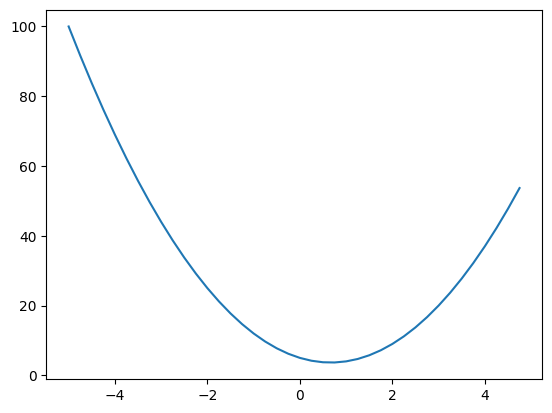

In [83]:
plt.plot(xs,ys)

- For function $f(x) = 3\cdot x^2-4 \cdot x + 5$ the derivative is  ${\textstyle {\frac {df(x)}{dx}}} = 6\cdot x -4$
- If we substitute x= 3 we get that the derivative for $x =3$ is $14$
- Below we use the mathematical formula where we bump $x$ by a small value $h$ and find the slope. This method can be used to check gradients

In [84]:
# This is the slope for x = 3
h = 0.00000000001
x = 3
(f(x+h) - f(x) )/ h

14.000178794049134

In [85]:
# This is the slope for x = 2/3 and this happens to be 0 at the point for this time
h = 0.00000000001
x = 3
(f(x+h) - f(x) )/ h

14.000178794049134

In [86]:
# More complex function
a = 2.0
b = -3.0
c = 10.0
d = a*b+ c
print(d)

4.0


In [87]:
# let's see the affect of "a" variable on the value of "d"
print("Affect of a on the value d")
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+ c
a+=h
d2 = a*b+ c

print(f"d1:{d1}")
print(f"d2:{d2}")
print(f"slope: {(d2-d1)/h}")

Affect of a on the value d
d1:4.0
d2:3.999699999999999
slope: -3.000000000010772


In [88]:
# let's see the affect of "b" variable on the value of "d"
print("Affect of b on the value d")
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+ c
b+=h
d2 = a*b+ c

print(f"d1:{d1}")
print(f"d2:{d2}")
print(f"slope: {(d2-d1)/h}")

Affect of b on the value d
d1:4.0
d2:4.0002
slope: 2.0000000000042206


In [89]:
# let's see the affect of "c" variable on the value of "d"
print("Affect of c on the value d")
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+ c
c+=h
d2 = a*b+ c

print(f"d1:{d1}")
print(f"d2:{d2}")
print(f"slope: {(d2-d1)/h}")

Affect of c on the value d
d1:4.0
d2:4.0001
slope: 0.9999999999976694


In [136]:
class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0                 # Assume no affect on output by default
    self._backward = lambda :None # Assume as leaf node
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, id={id(self)},label={self.label})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other,label=f"{str(other)}")
    out = Value(self.data + other.data,(self,other),"+")

    def _backward():
      # print(f"self.grad  = 1 * {out.grad}")
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward= _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out= Value(self.data * other.data,(self,other),"*")

    def _backward():
      # print(f"self.grad  = {other.data}* {out.grad}")
      self.grad  += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __radd__(self,other):
    return self * other

  def __rmul__(self,other):
    return self * other

  def __truediv__(self,other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def __pow__(self,other):
    assert isinstance(other,(float,int))
    out = Value(self.data ** other,(self,),label=f"**{other}" )

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),label="exp")

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x= self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out= Value(t,(self,),"tanh")

    def _backward():
      self.grad += (1-t**2) * out.grad

    out._backward = _backward
    return out

  # Back prop
  def backward(self):
    # print(self)
    topo = []
    visited=set()
    # Topological sort
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1
    for node in reversed(topo):
      # print(node)
      node._backward()



In [91]:
a= Value(2.0,label="a")
b= Value(-3.0,label="b")
c= Value(10.0,label="c")
e= a*b;e.label="e"
d= e + c;d.label="d"
f= Value(-2.0,label="f")
L= d*f;L.label="L"



In [92]:
a= Value(2.0,label="a")
b= Value(4.0,label="b")
print(a+1)

Value(data=3.0, id=137713099479632,label=)


In [93]:
# Graph Visualization (Not essential to autograd)
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

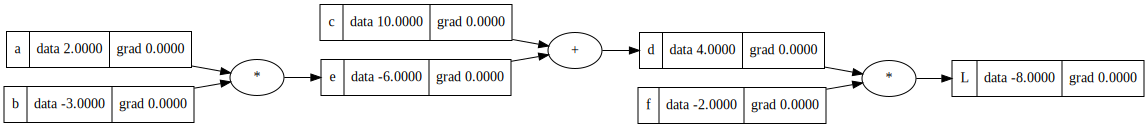

In [94]:
draw_dot(L)

In [95]:
def dummy_grad_check():
  h=0.0001
  a= Value(2.0,label="a")
  b= Value(-3.0,label="b")
  c= Value(10.0,label="c")
  e= a*b;e.label="e"
  d= e + c;d.label="d"
  f= Value(-2.0,label="f")
  L= d*f;L.label="L"
  L1=L.data

  # bump a by h
  a= Value(2.0+h,label="a")
  b= Value(-3.0,label="b")
  c= Value(10.0,label="c")
  e= a*b;e.label="e"
  d= e + c;d.label="d"
  f= Value(-2.0,label="f")
  L= d*f;L.label="L"
  L2=L.data

  print(f"grad {(L2-L1)/h}")



In [96]:
dummy_grad_check()

grad 6.000000000021544


## Understanding Backpropagation Through Computational Graph
- The computational graph is nothing but the sequence of mathematical operations that have taken place to get to the output laid out in a graph form.
- We always start backpropagation from the output and traverse throught the graph until we reach the inputs for the computation.
- Backpropagation relies mainly on the chain rule of differentiation ${\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}}$ .
- Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.
- ***For backpropagation, we can use the local derivatives at each node along with the chain rule to get the global derivative w.r.t. all the varaibles of responsible for the output***

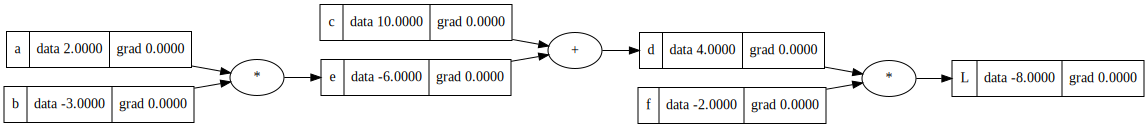

In [97]:
draw_dot(L)

- For the varaible $L =d \cdot f$, the derivative of L w.r.t L is $\frac{dL}{dL}=1.0$
- Now for $L =d \cdot f$, the derivative of L w.r.t d is $\frac{dL}{dd}=\frac{d}{dd} \cdot (d*f) => 1*f=>f,$ that implies $\frac{dL}{dd}=f=>-2.0$
- Because of symmetry we can say $\frac{dL}{df}=d=>4.0$
- $\frac{dL}{dc}= \frac{dL}{dd} \cdot \frac{dd}{dc}$, we need to find $\frac{dd}{dc}= \frac{d}{dc}\cdot(c+e)=>1+0=1$, substituting what we know $\frac{dL}{dc}= -2.0 \cdot 1 => -2.0$
- Because of symmetry we can say  $\frac{dL}{de}=\frac{dL}{dd}\cdot \frac{dd}{de}$, $\frac{dd}{de}= \frac{d}{de}(c+e)=>1$,$\frac{dL}{de}=-2.0\cdot 1.0=>-2.0$,
- $\frac{dL}{da}= \frac{dL}{de} /cdot \frac{de}{da} => -2.0 \cdot \frac{de}{da} $, $\frac{de}{da} = \frac{d}{da} (a*b)=b=>-3.0$,$\frac{dL}{da}=> -2.0 \cdot -3.0 =>6.0$
- Similarly, $\frac{dL}{db}= \frac{dL}{de} /cdot \frac{de}{db}=>-2.0 \cdot 2.0=>-4.0$

In [98]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

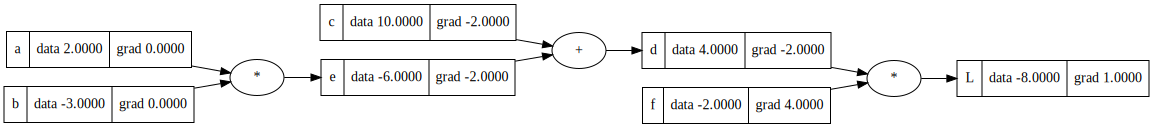

In [99]:
draw_dot(L)

In [100]:
# Simple neuron
# Inputs
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# Weights
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

# Products
x1w1 = x1 * w1;x1w1.label="x1w1"
x2w2 = x2 * w2;x2w2.label="x2w2"

# Sum of products
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# bias of the neuron
b = Value(6.8813735870195432,label="b")
# Neuron Output
n = x1w1x2w2 + b;n.label="n"

# Activation
o = n.tanh();o.label="o"

In [101]:
# Manual Backpropagation

# Base case Output gradient is always 1
o.grad = 1

# local derivative of tanh(n) = 1-tanh(n)^2
1- o.data**2
n.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [102]:
# Codified version of backpropagation
o.grad = 1.0
o._backward()

n._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()


self.grad  = 1 * 0.9999999999999999
self.grad  = 1 * 1.5
self.grad  = -3.0* 2.0
self.grad  = 1.0* 2.0


In [103]:
print(id(o))
o.backward()

137713099477904
Value(data=0.7071067811865476, id=137713099477904,label=o)
Value(data=0.7071067811865476, id=137713099477904,label=o)
Value(data=0.8813735870195432, id=137713099487984,label=n)
self.grad  = 1 * 1.4999999999999998
Value(data=6.881373587019543, id=137713099487264,label=b)
Value(data=-6.0, id=137713099480064,label=x1w1x2w2)
self.grad  = 1 * 3.0
Value(data=0.0, id=137713099484144,label=x2w2)
self.grad  = 1.0* 5.0
Value(data=0.0, id=137713099473968,label=x2)
Value(data=1.0, id=137713099481600,label=w2)
Value(data=-6.0, id=137713099481888,label=x1w1)
self.grad  = -3.0* 5.0
Value(data=-3.0, id=137713099485008,label=w1)
Value(data=2.0, id=137713099480112,label=x1)


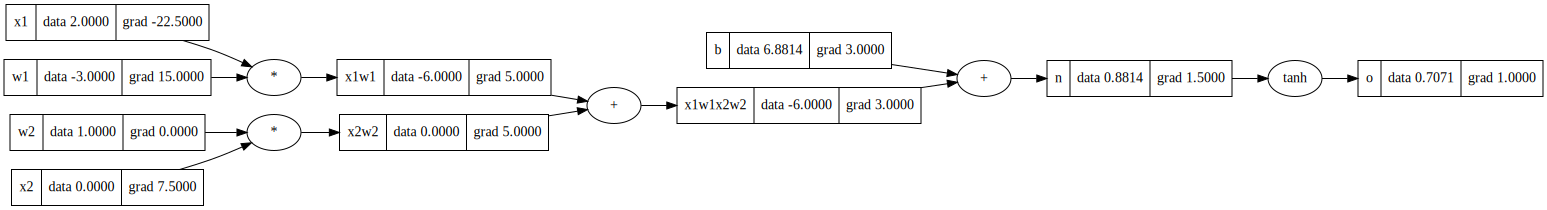

In [104]:
draw_dot(o)

In [105]:
x1w1._backward

<function __main__.Value.__mul__.<locals>._backward()>

In [106]:
# Topological sort order - Used to trace the backpropagation path
topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


In [107]:
topo

[Value(data=2.0, id=137713099480112,label=x1),
 Value(data=-3.0, id=137713099485008,label=w1),
 Value(data=-6.0, id=137713099481888,label=x1w1),
 Value(data=1.0, id=137713099481600,label=w2),
 Value(data=0.0, id=137713099473968,label=x2),
 Value(data=0.0, id=137713099484144,label=x2w2),
 Value(data=-6.0, id=137713099480064,label=x1w1x2w2),
 Value(data=6.881373587019543, id=137713099487264,label=b),
 Value(data=0.8813735870195432, id=137713099487984,label=n),
 Value(data=0.7071067811865476, id=137713099477904,label=o)]

In [108]:
o.grad = 1

In [109]:
id(o)

137713099477904

In [110]:
for node in reversed(topo):
  node._backward()
  print(node.grad)

1
self.grad  = 1 * 1.9999999999999996
1.9999999999999996
5.0
self.grad  = 1 * 5.0
5.0
self.grad  = 1.0* 10.0
10.0
17.5
0.0
self.grad  = -3.0* 10.0
10.0
35.0
-52.5


In [111]:
for node in reversed(topo):
  print(id(node))

137713099477904
137713099487984
137713099487264
137713099480064
137713099484144
137713099473968
137713099481600
137713099481888
137713099485008
137713099480112


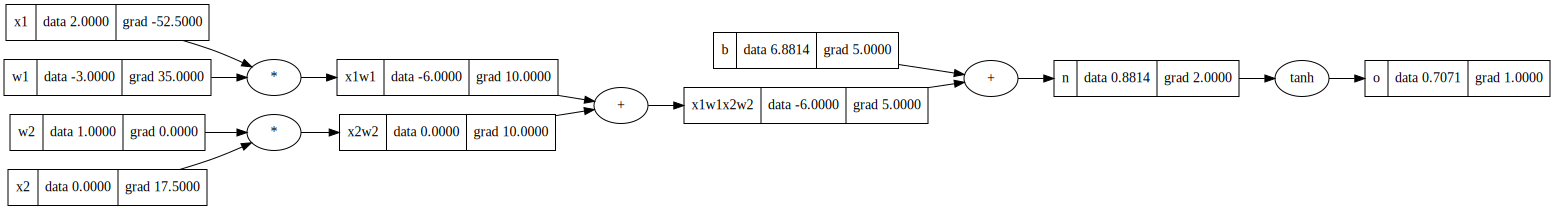

In [112]:
draw_dot(topo[-1])

Value(data=0.7071067811865477, id=137713099488944,label=o)
Value(data=0.7071067811865477, id=137713099488944,label=o)
self.grad  = 0.1464466094067262* 1
Value(data=4.828427124746192, id=137713099473632,label=)
self.grad  = 1 * 0.1464466094067262
Value(data=-1, id=137713099480160,label=-1)
Value(data=0.1464466094067262, id=137713099487696,label=**-1)
Value(data=6.828427124746192, id=137713099476656,label=)
self.grad  = 1 * -0.10355339059327374
Value(data=5.828427124746192, id=137713099482992,label=exp)
Value(data=1.7627471740390863, id=137713099475648,label=)
self.grad  = 2* 0.25
Value(data=2, id=137713099484528,label=)
Value(data=0.8813735870195432, id=137713099483712,label=n)
self.grad  = 1 * 0.5
Value(data=-6.0, id=137713099473488,label=x1w1x2w2)
self.grad  = 1 * 0.5
Value(data=-6.0, id=137713099486640,label=x1w1)
self.grad  = -3.0* 0.5
Value(data=2.0, id=137713099480544,label=x1)
Value(data=-3.0, id=137713099480208,label=w1)
Value(data=0.0, id=137713099479968,label=x2w2)
self.grad  

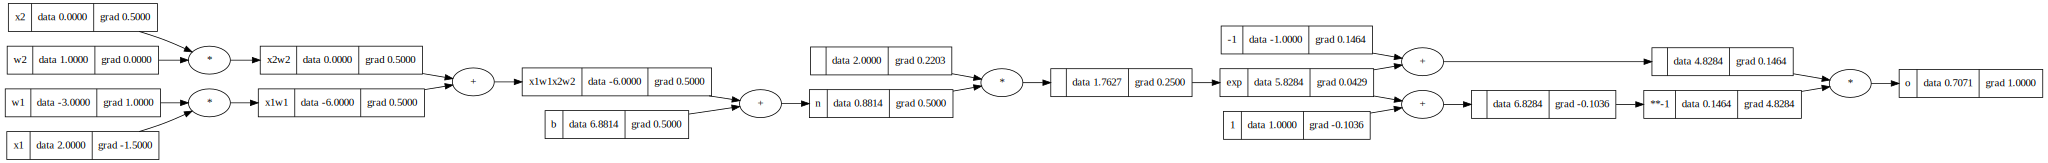

In [113]:
# Simple neuron with tanh built atomically
# Inputs
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# Weights
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

# Products
x1w1 = x1 * w1;x1w1.label="x1w1"
x2w2 = x2 * w2;x2w2.label="x2w2"

# Sum of products
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# bias of the neuron
b = Value(6.8813735870195432,label="b")
# Neuron Output
n = x1w1x2w2 + b;n.label="n"

# Activation tanh =(e^2x-1)/e^2x+1
e = (2*n).exp()
o = (e-1)/(e+1);o.label="o"
o.backward()
draw_dot(o)

#### Implementing the same in pytorch

In [114]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = (x1*w1) + (x2*w2) +  b
o = torch.tanh(n)
o.backward()
print(o.data.item())

print("="*10)
print(f"x1: {x1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"w2: {w2.grad.item()}")

0.7071066904050358
x1: -1.5000003851533106
x2: 0.5000001283844369
w1: 1.0000002567688737
w2: 0.0


In [137]:
class Neuron:
  # Initializing the weights and biases randomly
  def __init__(self,units):
    self.w = [Value(random.uniform(-1,1)) for _ in range(units)]
    self.b = Value(random.uniform(-1,1))

  # Forward pass on the neuron
  def __call__(self,x):
    act = sum([wi*xi for wi,xi in zip(self.w,x)],self.b)
    return act.tanh()
  def parameters(self):
    return self.w + [self.b]

class Layer:
  # Initialize the layer of neurons
  # nin -> Input dimension and nout -> number or neurons in layer
  def __init__(self,nin,nout):
    self.layer = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    out = [n(x) for n in self.layer]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for neuron in self.layer for p in neuron.parameters()]


class MLP:
  # Initialize the Multi Layer Perceptron
  def __init__(self,nin,nout):
    sz = [nin] + nout
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nout))]


  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0.0

  def update_parameters(self):
    for p in self.parameters():
      p.data += -0.05 * p.grad

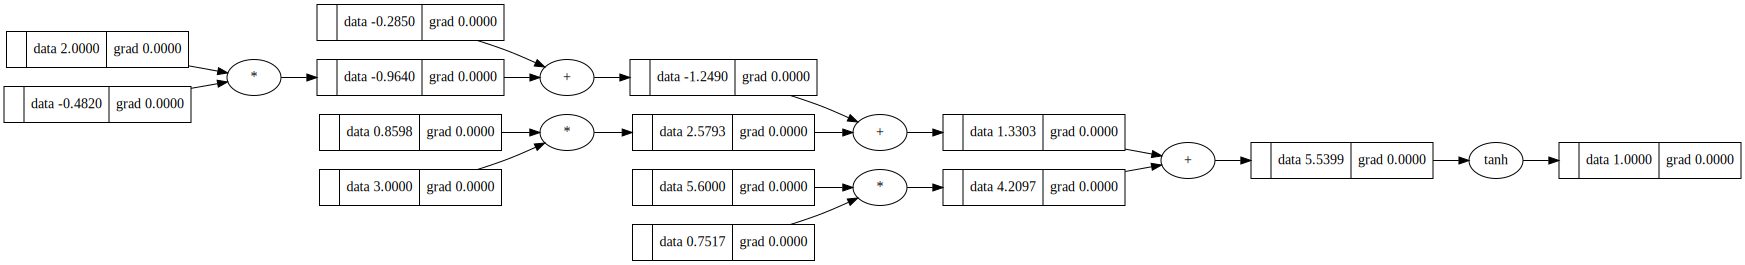

In [116]:
# Single Neuron forward propagation
x = [2.0,3.0,5.6]
n=Neuron(3)
single_neuron_output = n(x)
draw_dot(single_neuron_output)

In [117]:
# Single Layer Forward propagation
x = [1.2,4.3,55.5,100.0]
test_layer = Layer(4,3)
test_layer_out = test_layer(x)
print(test_layer_out)
# draw_dot(test_layer_out[-1])

[Value(data=0.9999999999999803, id=137713109831872,label=), Value(data=-1.0, id=137713109832832,label=), Value(data=-0.9999900049364372, id=137713109833984,label=)]


In [133]:
# MLP forwaed propagation

mlp = MLP(3,[4,4,1])
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.7508186657406622, id=137713095014288,label=),
 Value(data=0.7908645400303159, id=137713109609888,label=),
 Value(data=-0.9268580145239934, id=137713097225360,label=),
 Value(data=0.7011992946552991, id=137713095100592,label=)]

In [119]:
# MSE loss
loss = sum(y_pred - y_truth  for y_pred, y_truth in zip(ypred,ys))
loss

Value(data=1.179701274319129, id=137713109720256,label=)

In [120]:
loss.backward()

Value(data=1.179701274319129, id=137713109720256,label=)
Value(data=1.179701274319129, id=137713109720256,label=)
self.grad  = 1 * 1
Value(data=0.8780145031009909, id=137713109728992,label=)
self.grad  = 1 * 1.0
Value(data=-0.0, id=137713109827648,label=)
self.grad  = 0* 1.0
Value(data=-1.5217218092745137, id=137713109841904,label=)
self.grad  = 1 * 0.0
Value(data=-1.0, id=137713109834848,label=-1.0)
Value(data=-0.5217218092745137, id=137713099776128,label=)
Value(data=-0.5787025949169309, id=137713099775984,label=)
self.grad  = 1 * 0.0
Value(data=-0.3791811947734715, id=137713099775792,label=)
self.grad  = 1 * 0.0
Value(data=-0.2350413627381013, id=137713099775600,label=)
self.grad  = 1 * 0.0
Value(data=-0.05520596591008922, id=137713099775408,label=)
self.grad  = 1 * 0.0
Value(data=-0.05157306157787048, id=137713099774688,label=)
self.grad  = -0.8562428849694955* 0.0
Value(data=-0.8562428849694955, id=137713099769216,label=)
Value(data=-1.279092297606819, id=137713099769072,label=)
s

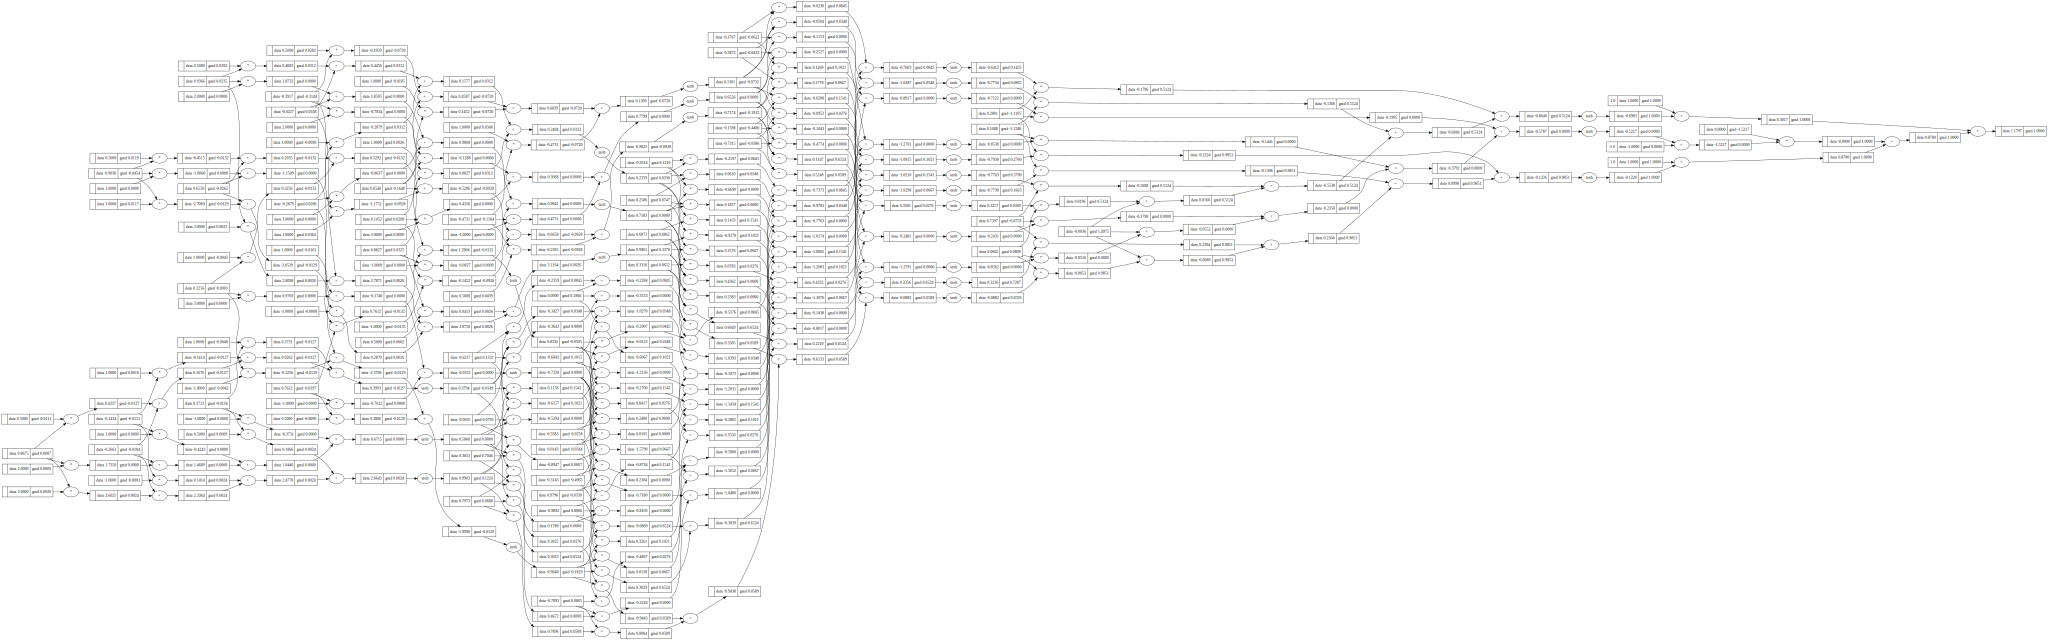

In [121]:
draw_dot(loss)

In [161]:
# MLP architecture

mlp = MLP(3,[4,4,1])
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0]

In [162]:
for i in range(225):
  # Forward Propagation
  ypred = [mlp(x) for x in xs]

  # Claculate loss
  loss = sum((y_pred - y_truth)**2 for  y_truth, y_pred in zip(ys,ypred))

  # Backward Propagation
  mlp.zero_grad()
  loss.backward()

  # Update Parameters
  mlp.update_parameters()

  print(f"epoch {i} : loss {loss.data}")

epoch 0 : loss 3.3806853125222074
epoch 1 : loss 1.762226946113127
epoch 2 : loss 1.0553388836842563
epoch 3 : loss 0.6859948560704436
epoch 4 : loss 0.4799795194676475
epoch 5 : loss 0.359686902366513
epoch 6 : loss 0.2821845530886437
epoch 7 : loss 0.22914656268646022
epoch 8 : loss 0.19112322083870026
epoch 9 : loss 0.16281081713238227
epoch 10 : loss 0.14106606300876262
epoch 11 : loss 0.1239334759230474
epoch 12 : loss 0.11014424599035515
epoch 13 : loss 0.09884474566466292
epoch 14 : loss 0.08944246870556707
epoch 15 : loss 0.0815148939032747
epoch 16 : loss 0.07475354628449224
epoch 17 : loss 0.0689285225014855
epoch 18 : loss 0.06386533318184813
epoch 19 : loss 0.05942939146227545
epoch 20 : loss 0.05551538144199153
epoch 21 : loss 0.05203981950201475
epoch 22 : loss 0.04893575201836278
epoch 23 : loss 0.04614891184087788
epoch 24 : loss 0.043634889343485625
epoch 25 : loss 0.04135702104279169
epoch 26 : loss 0.03928479356909042
epoch 27 : loss 0.03739262300456851
epoch 28 : lo

In [163]:
ypred

[Value(data=0.9374243548564889, id=137713094943712,label=),
 Value(data=-0.9747642479007923, id=137713094744944,label=),
 Value(data=-0.9664221355528515, id=137713090651008,label=),
 Value(data=0.9677986794454482, id=137713098879136,label=)]

In [151]:
ypred

[Value(data=-0.9818294141178902, id=137713093869728,label=),
 Value(data=-0.9832285950417928, id=137713097555296,label=),
 Value(data=-0.9891803222894522, id=137713094191776,label=),
 Value(data=-0.9828846005455235, id=137713094347216,label=)]